# Black-box Variational Inference

## Learning Goals:

1. Implement BBVI with the reparametrization trick
2. test the algorithm on logistic regression models

3. Bonus, see what happens if you use BBVI with mean field gaussian to approximate a mixture of two gaussian distributtions :)


### Load necessary libraries

In [113]:
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd

import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import pandas as pd
import scipy
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [114]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.5
        linewidths= 0.1
        
    i = 0
    
    YY = np.zeros(models[0].predict(xx).shape).reshape((n, n))
    for model in models:

#         yy = model.predict_proba(xx)
        yy = model.predict_proba(xx)[:,1]
        
        # plot decision boundary
        yy = yy.reshape((n, n))
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        # calculate accumulated dicision surface in the for loop
        YY += yy  

    # Plot decision surface
    YY /= len(models)
    if shaded:
        if len(models)==1:
            vmin=0
            vmax=1
            levels = np.linspace(vmin, vmax, 20+1)
            img = ax.contourf(x1, x2, YY, cmap='bwr',levels=levels, alpha = .3, vmin=vmin, vmax=vmax)
            fig.colorbar(img)
        else:
            vmin=0
            vmax=1
            levels = np.linspace(vmin, vmax, 20+1)
            img = ax.contourf(x1, x2, YY, cmap='bwr',levels=levels, alpha = 50./len(models), vmin=vmin, vmax=vmax)
            fig.colorbar(img)

        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

**Exercise 1: BBVI on bayesian logistic regression**
Implement the reparametrization gradient estimator and use it to approximate the posterior of the following Bayesian logistic regression model:


$$
w \sim \mathcal{N}(0, \sigma^2_w \mathbf{I})
$$

$$
Y^{(n)} \sim Ber(\text{sigm}(f(x^{(n)};W)))
$$

where f(x;W) is a logistic regression model. 


In [115]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    ''' A numpy implementation for logistic regression models. To be used for BBVI.
    '''
    
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes
        self.D = len(slopes) + 1
    def predict(self, x):
        x = x.T
        y = sigmoid(np.matmul(self.slopes, x) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        x = x.T
        output = sigmoid(np.matmul(self.slopes, x) + self.intercept)
        return np.array([1-output, output]).T

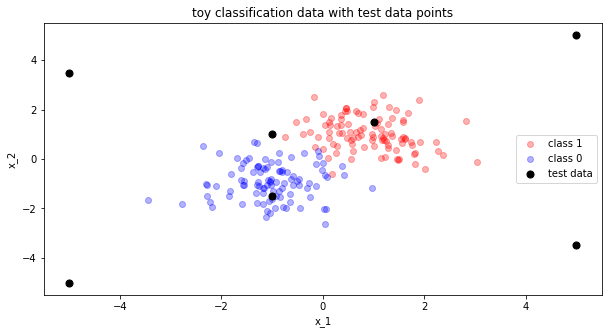

In [116]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

In [117]:
poly_degree = 2 # degrees of polynomial. if set to 1, it reduces to linear logistic regression.

poly = PolynomialFeatures(poly_degree,include_bias=False)
x_poly = poly.fit_transform(x)
# train a logistic regression model on the data with maximum likelihood estimation
# We will be using sklearn implementation
model_MLE = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1);
model_MLE.fit(x_poly,y)

LogisticRegression(solver='saga', tol=0.1)

In [118]:
# We can plug the MLE parameters into our logistic regression implemented in numpy

model = Bayesian_logistic_regression(model_MLE.intercept_,model_MLE.coef_.flatten())
model.predict(x_poly) # it works! 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

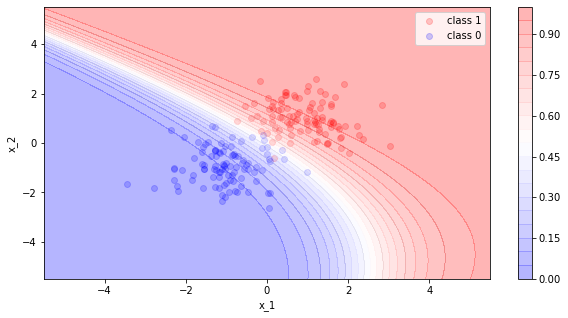

In [119]:
# Getting formiliar with the plotting function that we will be using to plot decision boundaries when we do bayesian inference

# The plotting function would take in a list of models sampled from posterior.

models = [model]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, models, ax, poly_degree= poly_degree)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [120]:
# implementing BBVI on bayesian logistic regression
# todo: add function annotation!!

def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return np.array(mean), np.array(log_std)

    def negative_gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = np.random.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = negative_gaussian_entropy(log_std) + np.mean(logprob(samples, t)) # tell people what t does
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


def forward(W, x):
    '''
    W: (D,) a vector of all the weights, s.t. W[0] is the intercept and W[1:] are the slopes
    x: (N,D-1), input for variational inference 
    '''
#     print(W.shape)
    D = x.shape[-1]+1
    x = x.T.reshape((1,D-1,-1))
    W = W.T
    slopes = W[1:].reshape((-1,1,D-1))
    intercept = W[0].reshape((-1,1,1))

    y = sigmoid(np.matmul(slopes, x) + intercept)
    assert(y.shape[1]==1)
#     print(y.shape)
    return y

def variational_inference(Sigma_W, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for unit test'''
    '''
        Sigma_W: (D,D) (diagnal) covariance matrix for the prior on W
        y_train: (N,) y_labels for training
        x_train: (N,D-1) x features without the biased term
        forward: (function) the vecterized implementation of the forward function f(W,X)
        S: number of samples to draw from the N(0,I) for estimating the ELBO gradient
        max_iteration: the max number of training steps
        step_size: the learning rate
    '''
    
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W): 
        assert(W.shape == (S,D))
        
        # you have to implement the normal pdf in numpy for the autograd package to work

        constant_W = -0.5 * (np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        assert(log_p_W.shape[0]==S)
        
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        assert(W.shape == (S,D))
        
        # you have to implement conditioned log likelihood, log(p(Y|X,W))
        
        output = forward(W, x_train) # (100,1,200)
#         print(y_train.shape) (200,)

        log_condition = np.sum(y_train * np.log(output +1e-10) + (1- y_train) * (np.log(1-output+1e-10)),axis = 2)
        
        assert(log_condition.shape[0]==S)
        
        return log_condition[:,0]

    #define the log joint density
    def log_density(w, t):
#         print((log_lklhd(w) + log_prior(w)).shape)
        return log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = -1*np.ones(D)
    init_log_std = -1 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 


In [121]:
D = model.D
weight_noise = 1**2
Sigma_W = weight_noise * np.eye(D)

paras = variational_inference(Sigma_W, y, x_poly, forward, S = 100, max_iteration=5000, step_size=1e-3, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -679.5362991187774; gradient mag: 258.1303397821716
Iteration 100 lower bound -634.4294566043295; gradient mag: 258.1861568550914
Iteration 200 lower bound -562.8716068956751; gradient mag: 253.3796409219647
Iteration 300 lower bound -489.22564275616224; gradient mag: 248.49960360493657
Iteration 400 lower bound -449.1644334454288; gradient mag: 245.4505352264079
Iteration 500 lower bound -380.1962953169271; gradient mag: 235.23710112119883
Iteration 600 lower bound -328.999267707173; gradient mag: 224.43592918492263
Iteration 700 lower bound -283.8697528870525; gradient mag: 216.11493552596949
Iteration 800 lower bound -238.74581506476937; gradient mag: 190.83295494516747
Iteration 900 lower bound -204.6803008837319; gradient mag: 169.1399753487418
Iteration 1000 lower bound -174.81200940654935; gradient mag: 132.07748219643764
Iteration 1100 lower bound -158.06269690526148; gradient mag: 106.67918143907859
Iteration 1200 lo

In [122]:
# sample 1000 sets of W from the VI posterior

mean, log_std = paras[:D], paras[D:]
samples = np.random.randn(1000, D) * np.exp(log_std) + mean

# sample a 100 of those models

posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)

models = []
for index in posterior_samples_index:
    sample = np.array(samples[index])#.reshape(1,-1)
    model = Bayesian_logistic_regression(sample[0],sample[1:])
    models.append(model)

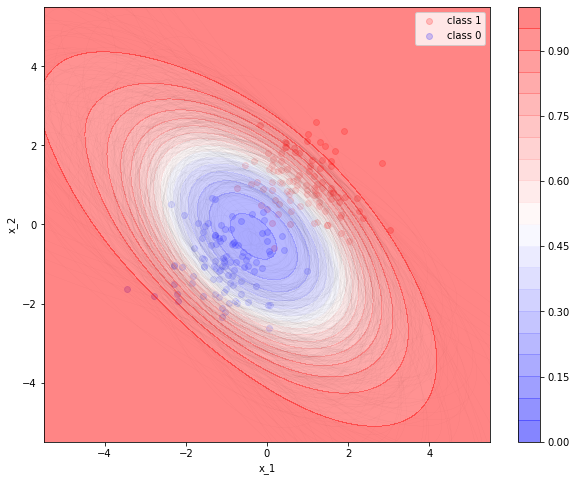

In [123]:
# plot the average decision boundaries from the 100 samples (posterior predictive)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

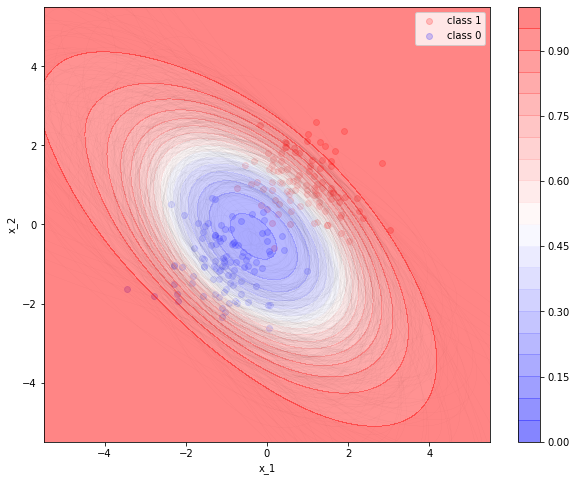

In [124]:
# plot the average decision boundaries from the 100 samples (posterior predictive)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

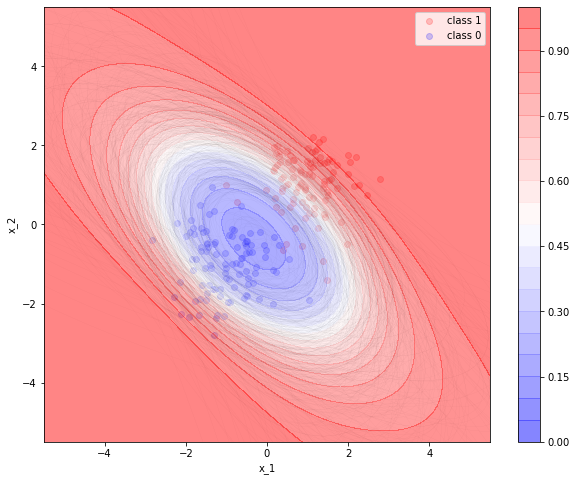

In [71]:
# plot the average decision boundaries from the 100 samples (posterior predictive)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x, y, models, ax, poly_degree=poly_degree)

**Bonus Exercise:** Using BBVI to approximate a mixture of two Gaussian distribution

Let's set the unnormalized true posterior distribution to be:
$$
p(\mathbf{W}) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \mathbf{W}) = 0.2 \mathcal{N}(\mathbf{W}; -1, 0.5) + 0.8 \mathcal{N}(\mathbf{W}; 4, 2)
$$
where $\mathbf{W} \in \mathbb{R}$.

Implement the reparametrization gradient estimator, for your choice of $\mu$ and $\Sigma$ (in our case since $W$ is one dimensional, $\mu$ and $\Sigma$ are just scalars). 

Note that the closed form expression for the entropy of a normal distribution is $\frac{1}{2}\log(2\pi e \Sigma)$, again, where $\Sigma$ is just a scalar representing the variance of the 1-dimensional $W$.


In [105]:
def variational_inference(S, max_iteration, step_size, verbose=True):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = 1
    #define the log joint density
    def log_density(w, t):
        #define a the pdf of a normal distribution to help define the mixture of Guassians pdf
        log_gaussian = lambda mean, var: -0.5 * np.log(var * 2 * np.pi) + -0.5 * (w - mean)**2 / var

        #implement log (0.5 N(transformed_epsilons; -1, 0.5) + 0.8 N(transformed_epsilons; 4, 2)) using the log_gaussian function defined above
        #for numeric stability reasons, you need to use the logsumexp function in your implementation
        argument = np.array((np.log(0.2) + log_gaussian(-1, 0.5), np.log(0.8) + log_gaussian(4, 2)))
        log_posterior_pdf = sp.special.logsumexp(argument, axis=0)
        return log_posterior_pdf

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.ones(D)
    init_log_std = -100 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    variational_mean = variational_params[0]
    variational_var = np.exp(variational_params[1])**2
    return variational_mean, variational_var

In [106]:
S = 10
max_iteration = 6000
step_size = 1e-1
variational_mean, variational_var = variational_inference(S, max_iteration, step_size)

Optimizing variational parameters...
Iteration 0 lower bound -102.23639952071512; gradient mag: 1.457493238241126
Iteration 100 lower bound -90.06978870210887; gradient mag: 1.0000357296227007
Iteration 200 lower bound -80.06971734184674; gradient mag: 1.0000000001302396
Iteration 300 lower bound -70.0697174415858; gradient mag: 1.0000000000000098
Iteration 400 lower bound -60.06971754158557; gradient mag: 1.0
Iteration 500 lower bound -50.06971764158579; gradient mag: 1.0
Iteration 600 lower bound -40.06971774158601; gradient mag: 1.0
Iteration 700 lower bound -30.069717841586158; gradient mag: 1.0
Iteration 800 lower bound -20.069717941586024; gradient mag: 1.0
Iteration 900 lower bound -10.069718043116588; gradient mag: 0.9999999986424312
Iteration 1000 lower bound -0.32840960628302285; gradient mag: 0.6106364435449886
Iteration 1100 lower bound 0.1042081588025674; gradient mag: 0.13177106710391776
Iteration 1200 lower bound -0.3082176353845687; gradient mag: 0.5337337347104613
Iter

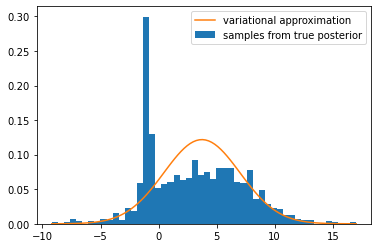

In [107]:
def posterior_samples(N=1000):
    indices = np.random.choice([0, 1], size=N, p=[0.2, 0.8])
    mu = [-1, 4]
    var = [0.5, 2]
    samples = []
    for index in indices:
        samples.append(np.random.normal(mu[index], var[index]**2))
    return np.array(samples)

samples = posterior_samples(N=1000) #sample from the true posterior

plt.hist(samples, bins=50, density=True, label='samples from true posterior') #we visualize samples from the true posterior
x = np.linspace(samples.min(), samples.max(), 100)
plt.plot(x, scipy.stats.norm.pdf(x, loc=variational_mean, scale=variational_var), label='variational approximation')
plt.legend(loc='best')
plt.show()